In [ ]:
# Install wandb for saving training logs
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=d17f6334a091e834393beeb89d3564f87cf41ffa18a7438bcb7e4f6bc2d6905d
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
import time
import math
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

### VGG model

In [ ]:
class VGG19_with_bn(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19_with_bn, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv15 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
  
        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # Initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        x = self.relu(self.bn1(self.conv1(input)))
        x = self.relu(self.bn1(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn2(self.conv3(x)))
        x = self.relu(self.bn2(self.conv4(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn3(self.conv5(x)))
        x = self.relu(self.bn3(self.conv6(x)))
        x = self.relu(self.bn3(self.conv7(x)))
        x = self.relu(self.bn3(self.conv8(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn4(self.conv9(x)))
        x = self.relu(self.bn4(self.conv10(x)))
        x = self.relu(self.bn4(self.conv11(x)))
        x = self.relu(self.bn4(self.conv12(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn4(self.conv13(x)))
        x = self.relu(self.bn4(self.conv14(x)))
        x = self.relu(self.bn4(self.conv15(x)))
        x = self.relu(self.bn4(self.conv16(x)))
        x = self.maxpool(x)

        x = torch.flatten(x, start_dim=1)
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        x = F.log_softmax(x, dim=1)
        return x


### Set hyperparameters and train model

In [ ]:
# Initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training parameters
epochs = 15
batch_size = 256
learning_rate = 0.01
momentum = 0.9
weight_decay = 5*10e-4
batch_norm = True

# Declare the network
model = VGG19_with_bn(num_classes=10).to(device)

# Loss function - Cross Entropy 
loss_fn = nn.CrossEntropyLoss().to(device)

# Optimizer - Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)
# .MultiStepLR(optimizer, milestones=[5,10], gamma=0.1)

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)), # change mnist to 3 channels instead of 1
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)), # change mnist to 3 channels instead of 1
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)),
    transforms.Resize((224, 224)),
])

train_data = datasets.MNIST(root='.', train=True, download=True, transform=train_transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


In [ ]:
# Initialize wandb
run = wandb.init(
    # set the wandb project where this run will be logged
    project="VGG-training-MNIST",
    
    # track hyperparameters and run metadata
    config={
        "architecture": "VGG",
        "dataset": "MNIST",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "momentum": momentum,
        "weight_decay": weight_decay,
        "batch_norm": batch_norm,
        "written_model": "yes",
        "others": "dropout 0.5 , lr scheduler 5, 0.1 gamma, weight init",
        "optimizer": "sgd",
        "log_softmax": "yes"
    }
)

# Keep track of training and test loss
total_loss = [[], [], []]

wandb: Currently logged in as: temitope-joloko. Use `wandb login --relogin` to force relogin


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = []

    for (images, labels) in tqdm((dataloader)):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        loss = loss_fn(pred, labels)
      
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

    scheduler.step()
    epoch_loss = np.mean(running_loss)
    print(f'loss: {epoch_loss:.3f}')
    return epoch_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, correct_5 = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            
            # Calculate top-5 accuracy
            _, pred_5 = pred.topk(5)

            for i in range(len(labels)):
                if labels[i] in pred_5[i]:
                    correct_5 += 1


    test_loss /= num_batches
    correct /= size
    correct_5/=size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Top-5 Accuracy: {(100*correct_5):>0.1f}%, \n Loss: {test_loss:>8f} \n")
    
    return test_loss, correct*100, correct_5*100

In [ ]:
print("Starting Training Loop...")
start_time = time.time()

for t in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {t+1}\n-------------------------------")

    epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, top1_accuracy, top5_accuracy = test_loop(test_dataloader, model, loss_fn)
    
    total_loss[0].append(t+1)
    total_loss[1].append(epoch_loss)
    total_loss[2].append(test_loss)
    
    wandb.log({ "training_loss": epoch_loss, "test_loss": test_loss, "acc": top1_accuracy, "top5_accuracy": top5_accuracy })

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("Epoch %d of %d with %.2f s" % (t + 1, epochs, per_epoch_ptime))


print("Done!")
end_time = time.time()
total_ptime = end_time - start_time
print("Total time %.2f" % (total_ptime))

Starting Training Loop...
Epoch 1
-------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 235/235 [03:34<00:00,  1.09it/s]


loss: 0.992
Test Error: 
 Accuracy: 89.6%, Top-5 Accuracy: 99.7%, 
 Loss: 0.306679 

Epoch 1 of 15 with 232.00 s
Epoch 2
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.14it/s]


loss: 0.214
Test Error: 
 Accuracy: 95.9%, Top-5 Accuracy: 99.9%, 
 Loss: 0.139477 

Epoch 2 of 15 with 224.19 s
Epoch 3
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.120
Test Error: 
 Accuracy: 97.0%, Top-5 Accuracy: 99.9%, 
 Loss: 0.096932 

Epoch 3 of 15 with 225.08 s
Epoch 4
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.091
Test Error: 
 Accuracy: 97.5%, Top-5 Accuracy: 100.0%, 
 Loss: 0.076016 

Epoch 4 of 15 with 224.39 s
Epoch 5
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.075
Test Error: 
 Accuracy: 98.0%, Top-5 Accuracy: 100.0%, 
 Loss: 0.063791 

Epoch 5 of 15 with 224.97 s
Epoch 6
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.057
Test Error: 
 Accuracy: 98.3%, Top-5 Accuracy: 100.0%, 
 Loss: 0.053457 

Epoch 6 of 15 with 225.02 s
Epoch 7
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.052
Test Error: 
 Accuracy: 98.3%, Top-5 Accuracy: 100.0%, 
 Loss: 0.052223 

Epoch 7 of 15 with 224.90 s
Epoch 8
-------------------------------


100%|██████████| 235/235 [03:31<00:00,  1.11it/s]


loss: 0.051
Test Error: 
 Accuracy: 98.5%, Top-5 Accuracy: 100.0%, 
 Loss: 0.050796 

Epoch 8 of 15 with 228.73 s
Epoch 9
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.050
Test Error: 
 Accuracy: 98.4%, Top-5 Accuracy: 100.0%, 
 Loss: 0.052195 

Epoch 9 of 15 with 224.70 s
Epoch 10
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.048
Test Error: 
 Accuracy: 98.5%, Top-5 Accuracy: 100.0%, 
 Loss: 0.047683 

Epoch 10 of 15 with 225.10 s
Epoch 11
-------------------------------


100%|██████████| 235/235 [03:28<00:00,  1.13it/s]


loss: 0.047
Test Error: 
 Accuracy: 98.5%, Top-5 Accuracy: 100.0%, 
 Loss: 0.050205 

Epoch 11 of 15 with 225.59 s
Epoch 12
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.049
Test Error: 
 Accuracy: 98.4%, Top-5 Accuracy: 100.0%, 
 Loss: 0.051796 

Epoch 12 of 15 with 225.10 s
Epoch 13
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.048
Test Error: 
 Accuracy: 98.5%, Top-5 Accuracy: 100.0%, 
 Loss: 0.049035 

Epoch 13 of 15 with 224.94 s
Epoch 14
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.048
Test Error: 
 Accuracy: 98.6%, Top-5 Accuracy: 100.0%, 
 Loss: 0.049231 

Epoch 14 of 15 with 225.04 s
Epoch 15
-------------------------------


100%|██████████| 235/235 [03:27<00:00,  1.13it/s]


loss: 0.048
Test Error: 
 Accuracy: 98.4%, Top-5 Accuracy: 100.0%, 
 Loss: 0.049014 

Epoch 15 of 15 with 225.00 s
Done!
Total time 3384.77


In [ ]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 98.5%, Top-5 Accuracy: 100.0%, 
 Loss: 0.049144 



(0.04914435325190425, 98.54, 99.99)

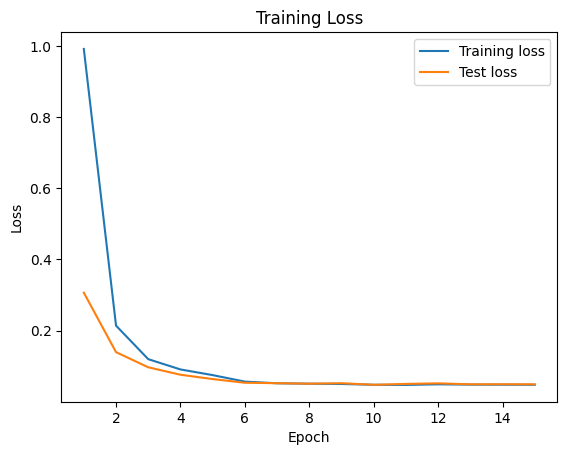

In [ ]:
plt.plot(total_loss[0], total_loss[1], label = "Training loss")
plt.plot(total_loss[0], total_loss[2], label = "Test loss")

# Add labels and title to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Close wandb run
run.finish()

acc,▁▆▇▇███████████
test_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
top5_accuracy,▁▆▇█▇██▇█▇█████
training_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
acc,98.36
test_loss,0.04901
top5_accuracy,99.99
training_loss,0.0478


In [ ]:
# Save model
# torch.save(model, 'vgg_final_mnist_model.pth')

torch.save(model.state_dict(), 'vgg_final_mnist_model_weights.pth')